In [1]:
# ==========================================
# Part 1: Â•ó‰ª∂ÂÆâË£ùËàáË®≠ÂÆö
# ==========================================

# ÂÆâË£ùÂøÖË¶ÅÂ•ó‰ª∂
!pip install pycocotools
!pip install albumentations
!pip install efficientnet-pytorch
!pip install timm
!pip install sklearn
!pip install matplotlib seaborn

# ÂåØÂÖ•Âü∫Êú¨Â•ó‰ª∂
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import requests
from urllib.parse import urlparse
import zipfile
from tqdm import tqdm
import random

# Ê∑±Â∫¶Â≠∏ÁøíÂ•ó‰ª∂
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import timm

# Ë©ï‰º∞Â•ó‰ª∂
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# COCO API
from pycocotools.coco import COCO

# Ë®≠ÂÆöË£ùÁΩÆ
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"‰ΩøÁî®Ë£ùÁΩÆ: {device}")

# Ë®≠ÂÆöÈö®Ê©üÁ®ÆÂ≠ê
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

print("Â•ó‰ª∂ÂÆâË£ùËàáË®≠ÂÆöÂÆåÊàêÔºÅ")

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=50da8a73912724b8074137cafd1e53bfd46e4e02ec5c354af3a170bf06910908
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet-pytorch
  error: subprocess-exited-with-error
  
  √ó python setup.py egg_info did not run successfully.
  ‚îÇ exit code: 1
  ‚ï∞‚îÄ> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

√ó Encountered error while generating package metadata.
‚ï∞‚îÄ> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
‰ΩøÁî®Ë£ùÁΩÆ: cuda
Â•ó‰ª∂ÂÆâË£ùËàáË®≠ÂÆöÂÆåÊàêÔºÅ


In [16]:
# ==========================================
# Part 2: Ë≥áÊñô‰∏ãËºâËàáËôïÁêÜ
# ==========================================

# ÂÆöÁæ©ÁõÆÊ®ôÈ°ûÂà•
TARGET_CATEGORIES = ['bear', 'elephant', 'airplane', 'train']
CATEGORY_TO_ID = {'bear': 23, 'elephant': 21, 'airplane': 5, 'train': 7}  # COCO category IDs
ID_TO_LABEL = {0: 'bear', 1: 'elephant', 2: 'airplane', 3: 'train'}

# ‰∏ãËºâCOCO annotations
def download_coco_annotations():
    """‰∏ãËºâCOCO annotationsÊ™îÊ°à"""
    annotations_dir = '/content/coco_annotations'
    os.makedirs(annotations_dir, exist_ok=True)

    # ‰∏ãËºâtrainÂíåvalÁöÑannotations
    urls = {
        'train': 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
    }

    for split, url in urls.items():
        zip_path = f'{annotations_dir}/annotations_trainval2017.zip'
        if not os.path.exists(zip_path):
            print(f"‰∏ãËºâ {split} annotations...")
            response = requests.get(url, stream=True)
            with open(zip_path, 'wb') as f:
                for chunk in tqdm(response.iter_content(chunk_size=8192)):
                    f.write(chunk)

            # Ëß£Â£ìÁ∏Æ
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(annotations_dir)

    return annotations_dir

# ‰∏ãËºâ‰∏¶ËôïÁêÜannotations
annotations_dir = download_coco_annotations()

# ËºâÂÖ•COCO API
train_ann_path = f"{annotations_dir}/annotations/instances_train2017.json"
val_ann_path = f"{annotations_dir}/annotations/instances_val2017.json"

coco_train = COCO(train_ann_path)
coco_val = COCO(val_ann_path)

def get_filtered_image_data(coco_api, split_name, max_images_per_class=2000):
    """Áç≤ÂèñÊåáÂÆöÈ°ûÂà•ÁöÑÂúñÁâáË≥áÊñô"""
    print(f"ËôïÁêÜ {split_name} Ë≥áÊñô...")

    # Áç≤ÂèñÁõÆÊ®ôÈ°ûÂà•ÁöÑcategory IDs
    target_cat_ids = []
    for cat_name in TARGET_CATEGORIES:
        cat_id = CATEGORY_TO_ID[cat_name]
        target_cat_ids.append(cat_id)

    image_data = []

    for idx, cat_name in enumerate(TARGET_CATEGORIES):
        cat_id = CATEGORY_TO_ID[cat_name]
        print(f"ËôïÁêÜÈ°ûÂà•: {cat_name} (ID: {cat_id})")

        # Áç≤ÂèñË©≤È°ûÂà•ÁöÑÊâÄÊúâÂúñÁâáID
        img_ids = coco_api.getImgIds(catIds=[cat_id])

        # ÈôêÂà∂ÂúñÁâáÊï∏Èáè
        if len(img_ids) > max_images_per_class:
            img_ids = random.sample(img_ids, max_images_per_class)

        print(f"  ÊâæÂà∞ {len(img_ids)} ÂºµÂúñÁâá")

        for img_id in img_ids:
            # Áç≤ÂèñÂúñÁâáË≥áË®ä
            img_info = coco_api.loadImgs(img_id)[0]

            # Áç≤ÂèñË©≤ÂúñÁâáÁöÑÊâÄÊúâannotations
            ann_ids = coco_api.getAnnIds(imgIds=img_id, catIds=target_cat_ids)
            anns = coco_api.loadAnns(ann_ids)

            # Ê™¢Êü•ÊòØÂê¶ÂåÖÂê´ÁõÆÊ®ôÈ°ûÂà•
            categories_in_image = set()
            for ann in anns:
                if ann['category_id'] in target_cat_ids:
                    cat_name_found = next(name for name, id in CATEGORY_TO_ID.items() if id == ann['category_id'])
                    categories_in_image.add(cat_name_found)

            # Â¶ÇÊûúÂúñÁâá‰∏ªË¶ÅÂåÖÂê´Áï∂ÂâçËôïÁêÜÁöÑÈ°ûÂà•ÔºåÂâáÊ∑ªÂä†Âà∞Ë≥áÊñôÈõÜ
            if cat_name in categories_in_image:
                image_data.append({
                    'image_id': img_id,
                    'file_name': img_info['file_name'],
                    'label': idx,  # ÈáçÊñ∞Á∑®Á¢ºÊ®ôÁ±§ 0,1,2,3
                    'category_name': cat_name,
                    'url': f"http://images.cocodataset.org/{'train2017' if split_name == 'train' else 'val2017'}/{img_info['file_name']}"
                })

    return image_data

# ËôïÁêÜË®ìÁ∑¥ÂíåÊ∏¨Ë©¶Ë≥áÊñô
train_data_full = get_filtered_image_data(coco_train, 'train', max_images_per_class=500) #1500
test_data = get_filtered_image_data(coco_val, 'val', max_images_per_class=30)  # ÂéüvalÈõÜ‰ΩúÁÇ∫test 400

# Â∞átrainÈõÜÂàÜÂâ≤ÁÇ∫ train (90%) Âíå validation (10%)
def split_train_validation(train_data, validation_ratio=0.1):
    """Â∞áË®ìÁ∑¥Ë≥áÊñôÂàÜÂâ≤ÁÇ∫Ë®ìÁ∑¥ÈõÜÂíåÈ©óË≠âÈõÜ"""
    print("ÂàÜÂâ≤Ë®ìÁ∑¥Ë≥áÊñôÁÇ∫ train (90%) Âíå validation (10%)...")

    # ÊåâÈ°ûÂà•ÂàÜÁµÑ
    class_data = {}
    for item in train_data:
        label = item['label']
        if label not in class_data:
            class_data[label] = []
        class_data[label].append(item)

    train_final = []
    val_data = []

    # ÊØèÂÄãÈ°ûÂà•ÂñÆÁç®ÂàÜÂâ≤
    for label, items in class_data.items():
        random.shuffle(items)  # Èö®Ê©üÊâì‰∫Ç
        split_point = int(len(items) * validation_ratio)

        val_data.extend(items[:split_point])  # Ââç10%‰ΩúÁÇ∫È©óË≠âÈõÜ
        train_final.extend(items[split_point:])  # Âæå90%‰ΩúÁÇ∫Ë®ìÁ∑¥ÈõÜ

    return train_final, val_data

# ÂàÜÂâ≤Ë≥áÊñôÈõÜ
train_data, val_data = split_train_validation(train_data_full, validation_ratio=0.1)

print(f"\nüìä Ë≥áÊñôÈõÜÂàÜÂâ≤ÁµêÊûú:")
print(f"Ë®ìÁ∑¥Ë≥áÊñô (train): {len(train_data)} ÂºµÂúñÁâá (ÂéütrainÁöÑ90%)")
print(f"È©óË≠âË≥áÊñô (validation): {len(val_data)} ÂºµÂúñÁâá (ÂéütrainÁöÑ10%)")
print(f"Ê∏¨Ë©¶Ë≥áÊñô (test): {len(test_data)} ÂºµÂúñÁâá (ÂéüvalÈõÜ)")

# Ê™¢Êü•ÂêÑÈ°ûÂà•ÂàÜÂ∏É
for split_name, data in [('Train', train_data), ('Validation', val_data), ('Test', test_data)]:
    print(f"\n{split_name} È°ûÂà•ÂàÜÂ∏É:")
    for i, cat_name in enumerate(TARGET_CATEGORIES):
        count = sum(1 for item in data if item['label'] == i)
        print(f"  {cat_name}: {count} Âºµ")

print("\nË≥áÊñôËôïÁêÜÂÆåÊàêÔºÅ")

loading annotations into memory...
Done (t=16.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
ËôïÁêÜ train Ë≥áÊñô...
ËôïÁêÜÈ°ûÂà•: bear (ID: 23)
  ÊâæÂà∞ 500 ÂºµÂúñÁâá
ËôïÁêÜÈ°ûÂà•: elephant (ID: 21)
  ÊâæÂà∞ 500 ÂºµÂúñÁâá
ËôïÁêÜÈ°ûÂà•: airplane (ID: 5)
  ÊâæÂà∞ 500 ÂºµÂúñÁâá
ËôïÁêÜÈ°ûÂà•: train (ID: 7)
  ÊâæÂà∞ 500 ÂºµÂúñÁâá
ËôïÁêÜ val Ë≥áÊñô...
ËôïÁêÜÈ°ûÂà•: bear (ID: 23)
  ÊâæÂà∞ 30 ÂºµÂúñÁâá
ËôïÁêÜÈ°ûÂà•: elephant (ID: 21)
  ÊâæÂà∞ 30 ÂºµÂúñÁâá
ËôïÁêÜÈ°ûÂà•: airplane (ID: 5)
  ÊâæÂà∞ 30 ÂºµÂúñÁâá
ËôïÁêÜÈ°ûÂà•: train (ID: 7)
  ÊâæÂà∞ 30 ÂºµÂúñÁâá
ÂàÜÂâ≤Ë®ìÁ∑¥Ë≥áÊñôÁÇ∫ train (90%) Âíå validation (10%)...

üìä Ë≥áÊñôÈõÜÂàÜÂâ≤ÁµêÊûú:
Ë®ìÁ∑¥Ë≥áÊñô (train): 1800 ÂºµÂúñÁâá (ÂéütrainÁöÑ90%)
È©óË≠âË≥áÊñô (validation): 200 ÂºµÂúñÁâá (ÂéütrainÁöÑ10%)
Ê∏¨Ë©¶Ë≥áÊñô (test): 120 ÂºµÂúñÁâá (ÂéüvalÈõÜ)

Train È°ûÂà•ÂàÜÂ∏É:
  bear: 450 Âºµ
  elephant: 450 Âºµ
  airplane: 450 Âºµ
  train: 450 Âºµ

Validation È°ûÂà•ÂàÜÂ∏É:
  bea

In [17]:
# ==========================================
# Part 3: Ë≥áÊñôÈõÜÈ°ûÂà•ËàáË≥áÊñôËºâÂÖ•
# ==========================================

class COCODataset(Dataset):
    """Ëá™ÂÆöÁæ©COCOË≥áÊñôÈõÜÈ°ûÂà•"""

    def __init__(self, data, transform=None, download_images=True):
        self.data = data
        self.transform = transform
        self.download_images = download_images
        self.images_dir = '/content/coco_images'
        os.makedirs(self.images_dir, exist_ok=True)

        if self.download_images:
            self._download_images()

    def _download_images(self):
        """‰∏ãËºâÂúñÁâáÂà∞Êú¨Âú∞"""
        print("ÈñãÂßã‰∏ãËºâÂúñÁâá...")

        for item in tqdm(self.data):
            img_path = os.path.join(self.images_dir, item['file_name'])
            if not os.path.exists(img_path):
                try:
                    response = requests.get(item['url'], timeout=10)
                    if response.status_code == 200:
                        with open(img_path, 'wb') as f:
                            f.write(response.content)
                except Exception as e:
                    print(f"‰∏ãËºâÂ§±Êïó {item['file_name']}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = os.path.join(self.images_dir, item['file_name'])

        try:
            # ËºâÂÖ•ÂúñÁâá
            image = Image.open(img_path).convert('RGB')
            label = item['label']

            # ÊáâÁî®ËΩâÊèõ
            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"ËºâÂÖ•ÂúñÁâáÈåØË™§ {item['file_name']}: {e}")
            # ËøîÂõû‰∏ÄÂÄãÁ©∫ÁôΩÂúñÁâá
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            if self.transform:
                image = self.transform(image)
            return image, item['label']

# ÂÆöÁæ©Ë≥áÊñôËΩâÊèõ
def get_transforms():
    """Áç≤ÂèñË®ìÁ∑¥ÂíåÈ©óË≠âÁöÑË≥áÊñôËΩâÊèõ"""

    # Ë®ìÁ∑¥ÊôÇÁöÑË≥áÊñôÂ¢ûÂº∑
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])  # ImageNetÊ®ôÊ∫ñÂåñ
    ])

    # È©óË≠âÊôÇÁöÑËΩâÊèõ
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

# ÂâµÂª∫ËΩâÊèõ
train_transform, val_transform = get_transforms()

# ÂâµÂª∫‰∏âÂÄãË≥áÊñôÈõÜ
print("ÂâµÂª∫Ë®ìÁ∑¥Ë≥áÊñôÈõÜ...")
train_dataset = COCODataset(train_data, transform=train_transform, download_images=False)

print("ÂâµÂª∫È©óË≠âË≥áÊñôÈõÜ...")
val_dataset = COCODataset(val_data, transform=val_transform, download_images=False)

print("ÂâµÂª∫Ê∏¨Ë©¶Ë≥áÊñôÈõÜ...")
test_dataset = COCODataset(test_data, transform=val_transform, download_images=False)

# ÂâµÂª∫Ë≥áÊñôËºâÂÖ•Âô®
batch_size = 32
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nË≥áÊñôËºâÂÖ•Âô®Ë®≠ÂÆöÂÆåÊàê:")
print(f"Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: {len(train_loader)} (Ê®£Êú¨Êï∏: {len(train_dataset)})")
print(f"È©óË≠âÊâπÊ¨°Êï∏: {len(val_loader)} (Ê®£Êú¨Êï∏: {len(val_dataset)})")
print(f"Ê∏¨Ë©¶ÊâπÊ¨°Êï∏: {len(test_loader)} (Ê®£Êú¨Êï∏: {len(test_dataset)})")
print(f"ÊâπÊ¨°Â§ßÂ∞è: {batch_size}")

# ÁèæÂú®‰∏ãËºâÂúñÁâá (ÂàÜÊâπÈÄ≤Ë°å‰ª•ÁØÄÁúÅË®òÊÜ∂È´î)
def download_images_in_batches(dataset, batch_size=100):
    """ÂàÜÊâπ‰∏ãËºâÂúñÁâá"""
    total_images = len(dataset.data)

    for start_idx in range(0, total_images, batch_size):
        end_idx = min(start_idx + batch_size, total_images)
        batch_data = dataset.data[start_idx:end_idx]

        print(f"‰∏ãËºâÁ¨¨ {start_idx//batch_size + 1} ÊâπÂúñÁâá ({start_idx+1}-{end_idx}/{total_images})")

        for item in tqdm(batch_data):
            img_path = os.path.join(dataset.images_dir, item['file_name'])
            if not os.path.exists(img_path):
                try:
                    response = requests.get(item['url'], timeout=10)
                    if response.status_code == 200:
                        with open(img_path, 'wb') as f:
                            f.write(response.content)
                except Exception as e:
                    print(f"‰∏ãËºâÂ§±Êïó {item['file_name']}: {e}")

# ÈñãÂßã‰∏ãËºâÂúñÁâá
print("\nÈñãÂßã‰∏ãËºâË®ìÁ∑¥ÂúñÁâá...")
download_images_in_batches(train_dataset)

print("\nÈñãÂßã‰∏ãËºâÈ©óË≠âÂúñÁâá...")
download_images_in_batches(val_dataset)

print("\nÈñãÂßã‰∏ãËºâÊ∏¨Ë©¶ÂúñÁâá...")
download_images_in_batches(test_dataset)

print("\nË≥áÊñôÈõÜËàáË≥áÊñôËºâÂÖ•Âô®Ê∫ñÂÇôÂÆåÊàêÔºÅ")

ÂâµÂª∫Ë®ìÁ∑¥Ë≥áÊñôÈõÜ...
ÂâµÂª∫È©óË≠âË≥áÊñôÈõÜ...
ÂâµÂª∫Ê∏¨Ë©¶Ë≥áÊñôÈõÜ...

Ë≥áÊñôËºâÂÖ•Âô®Ë®≠ÂÆöÂÆåÊàê:
Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: 57 (Ê®£Êú¨Êï∏: 1800)
È©óË≠âÊâπÊ¨°Êï∏: 7 (Ê®£Êú¨Êï∏: 200)
Ê∏¨Ë©¶ÊâπÊ¨°Êï∏: 4 (Ê®£Êú¨Êï∏: 120)
ÊâπÊ¨°Â§ßÂ∞è: 32

ÈñãÂßã‰∏ãËºâË®ìÁ∑¥ÂúñÁâá...
‰∏ãËºâÁ¨¨ 1 ÊâπÂúñÁâá (1-100/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:06<00:00,  1.26s/it]


‰∏ãËºâÁ¨¨ 2 ÊâπÂúñÁâá (101-200/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:03<00:00,  1.23s/it]


‰∏ãËºâÁ¨¨ 3 ÊâπÂúñÁâá (201-300/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:02<00:00,  1.23s/it]


‰∏ãËºâÁ¨¨ 4 ÊâπÂúñÁâá (301-400/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:00<00:00,  1.21s/it]


‰∏ãËºâÁ¨¨ 5 ÊâπÂúñÁâá (401-500/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:04<00:00,  1.24s/it]


‰∏ãËºâÁ¨¨ 6 ÊâπÂúñÁâá (501-600/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:09<00:00,  1.30s/it]


‰∏ãËºâÁ¨¨ 7 ÊâπÂúñÁâá (601-700/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:09<00:00,  1.29s/it]


‰∏ãËºâÁ¨¨ 8 ÊâπÂúñÁâá (701-800/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:10<00:00,  1.31s/it]


‰∏ãËºâÁ¨¨ 9 ÊâπÂúñÁâá (801-900/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:09<00:00,  1.29s/it]


‰∏ãËºâÁ¨¨ 10 ÊâπÂúñÁâá (901-1000/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [01:57<00:00,  1.18s/it]


‰∏ãËºâÁ¨¨ 11 ÊâπÂúñÁâá (1001-1100/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [01:54<00:00,  1.15s/it]


‰∏ãËºâÁ¨¨ 12 ÊâπÂúñÁâá (1101-1200/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [01:57<00:00,  1.17s/it]


‰∏ãËºâÁ¨¨ 13 ÊâπÂúñÁâá (1201-1300/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [01:58<00:00,  1.18s/it]


‰∏ãËºâÁ¨¨ 14 ÊâπÂúñÁâá (1301-1400/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:04<00:00,  1.25s/it]


‰∏ãËºâÁ¨¨ 15 ÊâπÂúñÁâá (1401-1500/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:14<00:00,  1.35s/it]


‰∏ãËºâÁ¨¨ 16 ÊâπÂúñÁâá (1501-1600/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:09<00:00,  1.29s/it]


‰∏ãËºâÁ¨¨ 17 ÊâπÂúñÁâá (1601-1700/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:08<00:00,  1.28s/it]


‰∏ãËºâÁ¨¨ 18 ÊâπÂúñÁâá (1701-1800/1800)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:07<00:00,  1.27s/it]



ÈñãÂßã‰∏ãËºâÈ©óË≠âÂúñÁâá...
‰∏ãËºâÁ¨¨ 1 ÊâπÂúñÁâá (1-100/200)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:07<00:00,  1.27s/it]


‰∏ãËºâÁ¨¨ 2 ÊâπÂúñÁâá (101-200/200)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [02:03<00:00,  1.24s/it]



ÈñãÂßã‰∏ãËºâÊ∏¨Ë©¶ÂúñÁâá...
‰∏ãËºâÁ¨¨ 1 ÊâπÂúñÁâá (1-100/120)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:40<00:00,  2.49it/s]


‰∏ãËºâÁ¨¨ 2 ÊâπÂúñÁâá (101-120/120)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:17<00:00,  1.14it/s]


Ë≥áÊñôÈõÜËàáË≥áÊñôËºâÂÖ•Âô®Ê∫ñÂÇôÂÆåÊàêÔºÅ


In [18]:
# ==========================================
# Part 4: EfficientNetÊ®°ÂûãÂÆöÁæ©
# ==========================================

class EfficientNetClassifier(nn.Module):
    """
    Âü∫ÊñºEfficientNetÁöÑ4È°ûÂà•ÂàÜÈ°ûÂô®

    ÈÅ∏ÊìáEfficientNetÁöÑÂéüÂõ†:
    1. ÊïàËÉΩÂÑ™ÁßÄÔºöÂú®ImageNet‰∏äÊúâÂæàÂ•ΩÁöÑÊ∫ñÁ¢∫ÁéáË°®Áèæ
    2. ÊïàÁéáÈ´òÔºöÁõ∏ËºÉÊñºÂÖ∂‰ªñÈ´òÊ∫ñÁ¢∫ÁéáÊ®°ÂûãÔºåÂèÉÊï∏ÈáèËºÉÂ∞ëÔºåÊé®ÁêÜÈÄüÂ∫¶Âø´
    3. ÂèØÊì¥Â±ïÔºöÊúâÂ§öÂÄãÁâàÊú¨(B0-B7)ÂèØÊ†πÊìöÈúÄÊ±ÇÈÅ∏Êìá
    4. È†êË®ìÁ∑¥Ê¨äÈáçÔºöÊúâImageNetÈ†êË®ìÁ∑¥Ê¨äÈáçÔºåÊúâÂä©ÊñºÈÅ∑ÁßªÂ≠∏Áøí
    5. Áèæ‰ª£Êû∂ÊßãÔºö‰ΩøÁî®‰∫ÜÊ∑±Â∫¶ÂèØÂàÜÈõ¢Âç∑Á©çÂíåÊ≥®ÊÑèÂäõÊ©üÂà∂
    """

    def __init__(self, model_name='efficientnet_b3', num_classes=4, pretrained=True, dropout_rate=0.3):
        super(EfficientNetClassifier, self).__init__()

        self.model_name = model_name
        self.num_classes = num_classes

        # ËºâÂÖ•È†êË®ìÁ∑¥ÁöÑEfficientNet
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # ÁßªÈô§ÂàÜÈ°ûÈ†≠
            global_pool=''  # ÁßªÈô§ÂÖ®ÂüüÊ±†Âåñ
        )

        # Áç≤ÂèñÁâπÂæµÁ∂≠Â∫¶
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            self.feature_dim = features.shape[1]

        # Ëá™ÂÆöÁæ©ÂàÜÈ°ûÈ†≠
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # ÂÖ®ÂüüÂπ≥ÂùáÊ±†Âåñ
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate/2),
            nn.Linear(256, num_classes)
        )

        # ÂàùÂßãÂåñÂàÜÈ°ûÈ†≠Ê¨äÈáç
        self._initialize_classifier()

    def _initialize_classifier(self):
        """ÂàùÂßãÂåñÂàÜÈ°ûÈ†≠ÁöÑÊ¨äÈáç"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # ÁâπÂæµÊèêÂèñ
        features = self.backbone(x)

        # ÂàÜÈ°û
        output = self.classifier(features)

        return output

    def freeze_backbone(self, freeze=True):
        """ÂáçÁµêÊàñËß£ÂáçbackboneÂèÉÊï∏"""
        for param in self.backbone.parameters():
            param.requires_grad = not freeze

    def unfreeze_last_layers(self, num_layers=2):
        """Ëß£ÂáçbackboneÁöÑÊúÄÂæåÂπæÂ±§"""
        # Áç≤ÂèñÊâÄÊúâÂèÉÊï∏
        all_params = list(self.backbone.named_parameters())

        # Ë®àÁÆóË¶ÅËß£ÂáçÁöÑÂèÉÊï∏Êï∏Èáè
        total_layers = len(all_params)
        unfreeze_from = max(0, total_layers - num_layers)

        # Ëß£ÂáçÊúÄÂæåÂπæÂ±§
        for i, (name, param) in enumerate(all_params):
            if i >= unfreeze_from:
                param.requires_grad = True
                print(f"Ëß£ÂáçÂ±§: {name}")

# ÂâµÂª∫Ê®°Âûã
def create_model(model_name='efficientnet_b3', num_classes=4, pretrained=True):
    """ÂâµÂª∫EfficientNetÂàÜÈ°ûÊ®°Âûã"""

    print(f"ÂâµÂª∫Ê®°Âûã: {model_name}")
    print(f"È°ûÂà•Êï∏Èáè: {num_classes}")
    print(f"‰ΩøÁî®È†êË®ìÁ∑¥Ê¨äÈáç: {pretrained}")

    model = EfficientNetClassifier(
        model_name=model_name,
        num_classes=num_classes,
        pretrained=pretrained,
        dropout_rate=0.3
    )

    # Â∞áÊ®°ÂûãÁßªÂà∞ÊåáÂÆöË£ùÁΩÆ
    model = model.to(device)

    # È°ØÁ§∫Ê®°ÂûãË≥áË®ä
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nÊ®°ÂûãË≥áË®ä:")
    print(f"Á∏ΩÂèÉÊï∏Èáè: {total_params:,}")
    print(f"ÂèØË®ìÁ∑¥ÂèÉÊï∏Èáè: {trainable_params:,}")
    print(f"ÁâπÂæµÁ∂≠Â∫¶: {model.feature_dim}")

    return model

# ÂâµÂª∫Ê®°ÂûãÂØ¶‰æã
model = create_model(
    model_name='efficientnet_b3',  # ‰ΩøÁî®B3ÁâàÊú¨ÔºåÂπ≥Ë°°ÊïàËÉΩÂíåÊïàÁéá
    num_classes=4,
    pretrained=True
)

print(f"\nÊ®°ÂûãÊû∂Êßã:")
print(model)

print(f"\nEfficientNetÊ®°ÂûãÂâµÂª∫ÂÆåÊàêÔºÅ")
print(f"Ê®°ÂûãÂ∑≤ÁßªËá≥Ë£ùÁΩÆ: {next(model.parameters()).device}")

ÂâµÂª∫Ê®°Âûã: efficientnet_b3
È°ûÂà•Êï∏Èáè: 4
‰ΩøÁî®È†êË®ìÁ∑¥Ê¨äÈáç: True

Ê®°ÂûãË≥áË®ä:
Á∏ΩÂèÉÊï∏Èáè: 11,617,068
ÂèØË®ìÁ∑¥ÂèÉÊï∏Èáè: 11,617,068
ÁâπÂæµÁ∂≠Â∫¶: 1536

Ê®°ÂûãÊû∂Êßã:
EfficientNetClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), str

In [20]:
# ==========================================
# Part 5: Ë®ìÁ∑¥Ë®≠ÂÆöËàáÂáΩÊï∏
# ==========================================

# ÊêçÂ§±ÂáΩÊï∏ÂíåÂÑ™ÂåñÂô®Ë®≠ÂÆö
def setup_training(model, learning_rate=0.001):
    """Ë®≠ÂÆöË®ìÁ∑¥Áõ∏ÈóúÁöÑÊêçÂ§±ÂáΩÊï∏„ÄÅÂÑ™ÂåñÂô®ÂíåÂ≠∏ÁøíÁéáË™øÂ∫¶Âô®"""

    # ÊêçÂ§±ÂáΩÊï∏ - ‰ΩøÁî®‰∫§ÂèâÁÜµÊêçÂ§±Ôºå‰∏¶Âä†ÂÖ•Ê®ôÁ±§Âπ≥Êªë
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # ÂÑ™ÂåñÂô® - ‰ΩøÁî®AdamWÔºåÂä†ÂÖ•Ê¨äÈáçË°∞Ê∏õ
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )

    # Â≠∏ÁøíÁéáË™øÂ∫¶Âô® - ‰ΩøÁî®È§òÂº¶ÈÄÄÁÅ´
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # Á¨¨‰∏ÄÊ¨°ÈáçÂïüÁöÑÈÄ±Êúü
        T_mult=2,  # ÊØèÊ¨°ÈáçÂïüÂæåÈÄ±ÊúüÁöÑÂÄçÊï∏
        eta_min=1e-6  # ÊúÄÂ∞èÂ≠∏ÁøíÁéá
    )

    return criterion, optimizer, scheduler

# Ë®ìÁ∑¥ÂáΩÊï∏
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Ë®ìÁ∑¥‰∏ÄÂÄãepoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc='Training')

    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Èõ∂Ê¢ØÂ∫¶
        optimizer.zero_grad()

        # ÂâçÂêëÂÇ≥Êí≠
        with torch.cuda.amp.autocast():  # ‰ΩøÁî®Ê∑∑ÂêàÁ≤æÂ∫¶Ë®ìÁ∑¥
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # ÂèçÂêëÂÇ≥Êí≠
        loss.backward()

        # Ê¢ØÂ∫¶Ë£ÅÂâ™Èò≤Ê≠¢Ê¢ØÂ∫¶ÁàÜÁÇ∏
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # ÂÑ™ÂåñÂô®Ê≠•ÈÄ≤
        optimizer.step()

        # Áµ±Ë®à
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

        # Êõ¥Êñ∞ÈÄ≤Â∫¶Ê¢ù
        current_acc = running_corrects.double() / total_samples
        progress_bar.set_postfix({
            'Loss': f'{running_loss / total_samples:.4f}',
            'Acc': f'{current_acc:.4f}'
        })

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc.item()

# È©óË≠âÂáΩÊï∏
def validate_epoch(model, val_loader, criterion, device):
    """È©óË≠â‰∏ÄÂÄãepoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation')

        for inputs, labels in progress_bar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # ÂâçÂêëÂÇ≥Êí≠
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Áµ±Ë®à
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            # Êî∂ÈõÜÈ†êÊ∏¨ÁµêÊûúÁî®ÊñºÊ∑∑Ê∑ÜÁü©Èô£
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Êõ¥Êñ∞ÈÄ≤Â∫¶Ê¢ù
            current_acc = running_corrects.double() / total_samples
            progress_bar.set_postfix({
                'Loss': f'{running_loss / total_samples:.4f}',
                'Acc': f'{current_acc:.4f}'
            })

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc.item(), all_preds, all_labels

# ‰∏ªË®ìÁ∑¥Âæ™Áí∞
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=50, patience=10, target_accuracy=0.95):
    """ÂÆåÊï¥ÁöÑË®ìÁ∑¥ÈÅéÁ®ã"""

    print(f"ÈñãÂßãË®ìÁ∑¥ÔºåÁõÆÊ®ôÊ∫ñÁ¢∫Áéá: {target_accuracy:.1%}")
    print(f"ÊúÄÂ§ßË®ìÁ∑¥Ëº™Êï∏: {num_epochs}")
    print(f"Êó©ÂÅúËÄêÂøÉÂÄº: {patience}")

    best_acc = 0.0
    best_model_wts = None
    patience_counter = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Ë®ìÁ∑¥ÈöéÊÆµ
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # È©óË≠âÈöéÊÆµ
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)

        # Â≠∏ÁøíÁéáË™øÂ∫¶
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Ë®òÈåÑÁµêÊûú
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Ë®ìÁ∑¥ - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')
        print(f'È©óË≠â - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')
        print(f'Â≠∏ÁøíÁéá: {current_lr:.6f}')

        # Ê™¢Êü•ÊòØÂê¶ÈÅîÂà∞ÁõÆÊ®ôÊ∫ñÁ¢∫Áéá
        if val_acc >= target_accuracy:
            print(f'\nüéâ ÈÅîÂà∞ÁõÆÊ®ôÊ∫ñÁ¢∫Áéá {target_accuracy:.1%}ÔºÅ')
            best_model_wts = model.state_dict().copy()
            best_acc = val_acc
            break

        # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
            patience_counter = 0
            print(f'üíæ Êñ∞ÁöÑÊúÄ‰Ω≥È©óË≠âÊ∫ñÁ¢∫Áéá: {best_acc:.4f}')
        else:
            patience_counter += 1
            print(f'È©óË≠âÊ∫ñÁ¢∫ÁéáÊú™ÊèêÂçá ({patience_counter}/{patience})')

        # Êó©ÂÅúÊ™¢Êü•
        if patience_counter >= patience:
            print(f'\nÊó©ÂÅúËß∏ÁôºÔºÅÊúÄ‰Ω≥È©óË≠âÊ∫ñÁ¢∫Áéá: {best_acc:.4f}')
            break

    # ËºâÂÖ•ÊúÄ‰Ω≥Ê®°ÂûãÊ¨äÈáç
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # ËøîÂõûË®ìÁ∑¥Ê≠∑Âè≤
    history = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_acc': best_acc
    }

    return model, history

# Ë®≠ÂÆöË®ìÁ∑¥ÂèÉÊï∏
criterion, optimizer, scheduler = setup_training(model, learning_rate=0.001)

print("Ë®ìÁ∑¥Ë®≠ÂÆöÂÆåÊàêÔºÅ")
print(f"ÊêçÂ§±ÂáΩÊï∏: {criterion}")
print(f"ÂÑ™ÂåñÂô®: {optimizer}")
print(f"Â≠∏ÁøíÁéáË™øÂ∫¶Âô®: {scheduler}")

Ë®ìÁ∑¥Ë®≠ÂÆöÂÆåÊàêÔºÅ
ÊêçÂ§±ÂáΩÊï∏: CrossEntropyLoss()
ÂÑ™ÂåñÂô®: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)
Â≠∏ÁøíÁéáË™øÂ∫¶Âô®: <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts object at 0x7cb49fd289e0>


In [21]:
# ==========================================
# Part 6: Ê®°ÂûãË®ìÁ∑¥Âü∑Ë°å
# ==========================================

# ÈñãÂßãË®ìÁ∑¥Ê®°Âûã
print("ÈñãÂßãË®ìÁ∑¥Ê®°Âûã...")
print(f"ÁõÆÊ®ôÈ°ûÂà•: {TARGET_CATEGORIES}")
print(f"Ë®ìÁ∑¥Ê®£Êú¨Êï∏: {len(train_data)}")
print(f"È©óË≠âÊ®£Êú¨Êï∏: {len(val_data)}")
print(f"‰ΩøÁî®Ë£ùÁΩÆ: {device}")

# Âü∑Ë°åË®ìÁ∑¥
trained_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,  # ÊúÄÂ§ßË®ìÁ∑¥Ëº™Êï∏
    patience=10,    # Êó©ÂÅúËÄêÂøÉÂÄº
    target_accuracy=0.95  # ÁõÆÊ®ôÊ∫ñÁ¢∫Áéá 95%
)

print(f"\nüéØ Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")
print(f"ÊúÄ‰Ω≥È©óË≠âÊ∫ñÁ¢∫Áéá: {training_history['best_acc']:.4f}")

# ‰øùÂ≠òÊ®°Âûã
model_save_path = '/content/best_efficientnet_model.pth'
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'model_architecture': 'efficientnet_b3',
    'num_classes': 4,
    'target_categories': TARGET_CATEGORIES,
    'training_history': training_history,
    'feature_dim': trained_model.feature_dim
}, model_save_path)

print(f"Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {model_save_path}")

# È°ØÁ§∫Ë®ìÁ∑¥Ê≠∑Âè≤ÊëòË¶Å
print(f"\nüìä Ë®ìÁ∑¥Ê≠∑Âè≤ÊëòË¶Å:")
print(f"Ë®ìÁ∑¥Ëº™Êï∏: {len(training_history['train_losses'])}")
print(f"ÊúÄÁµÇË®ìÁ∑¥Ê∫ñÁ¢∫Áéá: {training_history['train_accs'][-1]:.4f}")
print(f"ÊúÄÁµÇÈ©óË≠âÊ∫ñÁ¢∫Áéá: {training_history['val_accs'][-1]:.4f}")
print(f"ÊúÄ‰Ω≥È©óË≠âÊ∫ñÁ¢∫Áéá: {training_history['best_acc']:.4f}")

# Â¶ÇÊûúÈúÄË¶ÅÔºåÂèØ‰ª•ÈÄ≤Ë°åÂæÆË™øË®ìÁ∑¥
def fine_tune_training(model, train_loader, val_loader, target_accuracy=0.95):
    """ÂæÆË™øË®ìÁ∑¥ - Ëß£ÂáçÊõ¥Â§öÂ±§ÈÄ≤Ë°åÁ≤æÁ¥∞Ë™øÊï¥"""
    print("\nüîß ÈñãÂßãÂæÆË™øË®ìÁ∑¥...")

    # Ëß£ÂáçbackboneÁöÑÊúÄÂæåÂπæÂ±§
    model.unfreeze_last_layers(num_layers=10)

    # Èôç‰ΩéÂ≠∏ÁøíÁéáÈÄ≤Ë°åÂæÆË™ø
    fine_tune_optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0001,  # Êõ¥Â∞èÁöÑÂ≠∏ÁøíÁéá
        weight_decay=0.01
    )

    fine_tune_scheduler = optim.lr_scheduler.StepLR(
        fine_tune_optimizer,
        step_size=5,
        gamma=0.5
    )

    # ÂæÆË™øË®ìÁ∑¥
    fine_tuned_model, fine_tune_history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=fine_tune_optimizer,
        scheduler=fine_tune_scheduler,
        num_epochs=20,  # ËºÉÂ∞ëÁöÑË®ìÁ∑¥Ëº™Êï∏
        patience=5,     # ËºÉÂ∞èÁöÑËÄêÂøÉÂÄº
        target_accuracy=target_accuracy
    )

    return fine_tuned_model, fine_tune_history

# Ê™¢Êü•ÊòØÂê¶ÈúÄË¶ÅÂæÆË™ø
# if training_history['best_acc'] < 0.95:
#     print(f"\nÁï∂ÂâçÊúÄ‰Ω≥Ê∫ñÁ¢∫Áéá {training_history['best_acc']:.4f} < 95%ÔºåÈñãÂßãÂæÆË™ø...")
#     trained_model, fine_tune_history = fine_tune_training(
#         trained_model, train_loader, val_loader, target_accuracy=0.95
#     )

#     # Êõ¥Êñ∞Ë®ìÁ∑¥Ê≠∑Âè≤
#     training_history['fine_tune_history'] = fine_tune_history
#     training_history['final_best_acc'] = fine_tune_history['best_acc']

#     # ÈáçÊñ∞‰øùÂ≠òÊ®°Âûã
#     torch.save({
#         'model_state_dict': trained_model.state_dict(),
#         'model_architecture': 'efficientnet_b3',
#         'num_classes': 4,
#         'target_categories': TARGET_CATEGORIES,
#         'training_history': training_history,
#         'feature_dim': trained_model.feature_dim
#     }, model_save_path)

#     print(f"ÂæÆË™øÂæåÊúÄ‰Ω≥Ê∫ñÁ¢∫Áéá: {fine_tune_history['best_acc']:.4f}")

# print("\n‚úÖ Ê®°ÂûãË®ìÁ∑¥ÈöéÊÆµÂÆåÊàêÔºÅ")

ÈñãÂßãË®ìÁ∑¥Ê®°Âûã...
ÁõÆÊ®ôÈ°ûÂà•: ['bear', 'elephant', 'airplane', 'train']
Ë®ìÁ∑¥Ê®£Êú¨Êï∏: 1800
È©óË≠âÊ®£Êú¨Êï∏: 200
‰ΩøÁî®Ë£ùÁΩÆ: cuda
ÈñãÂßãË®ìÁ∑¥ÔºåÁõÆÊ®ôÊ∫ñÁ¢∫Áéá: 95.0%
ÊúÄÂ§ßË®ìÁ∑¥Ëº™Êï∏: 30
Êó©ÂÅúËÄêÂøÉÂÄº: 10

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/57 [00:00<?, ?it/s]/tmp/ipython-input-3103711691.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # ‰ΩøÁî®Ê∑∑ÂêàÁ≤æÂ∫¶Ë®ìÁ∑¥
Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  3.89it/s, Loss=0.5893, Acc=0.9400]


Ë®ìÁ∑¥ - Loss: 0.9478, Acc: 0.7761
È©óË≠â - Loss: 0.5893, Acc: 0.9400
Â≠∏ÁøíÁéá: 0.000976
üíæ Êñ∞ÁöÑÊúÄ‰Ω≥È©óË≠âÊ∫ñÁ¢∫Áéá: 0.9400

Epoch 2/30
--------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  3.86it/s, Loss=0.7122, Acc=0.8550]


Ë®ìÁ∑¥ - Loss: 0.6552, Acc: 0.8806
È©óË≠â - Loss: 0.7122, Acc: 0.8550
Â≠∏ÁøíÁéá: 0.000905
È©óË≠âÊ∫ñÁ¢∫ÁéáÊú™ÊèêÂçá (1/10)

Epoch 3/30
--------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.04it/s, Loss=0.4634, Acc=0.9500]


Ë®ìÁ∑¥ - Loss: 0.5629, Acc: 0.9094
È©óË≠â - Loss: 0.4634, Acc: 0.9500
Â≠∏ÁøíÁéá: 0.000794

üéâ ÈÅîÂà∞ÁõÆÊ®ôÊ∫ñÁ¢∫Áéá 95.0%ÔºÅ

üéØ Ë®ìÁ∑¥ÂÆåÊàêÔºÅ
ÊúÄ‰Ω≥È©óË≠âÊ∫ñÁ¢∫Áéá: 0.9500
Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: /content/best_efficientnet_model.pth

üìä Ë®ìÁ∑¥Ê≠∑Âè≤ÊëòË¶Å:
Ë®ìÁ∑¥Ëº™Êï∏: 3
ÊúÄÁµÇË®ìÁ∑¥Ê∫ñÁ¢∫Áéá: 0.9094
ÊúÄÁµÇÈ©óË≠âÊ∫ñÁ¢∫Áéá: 0.9500
ÊúÄ‰Ω≥È©óË≠âÊ∫ñÁ¢∫Áéá: 0.9500


ÈñãÂßãË©ï‰º∞Ë®ìÁ∑¥Â•ΩÁöÑÊ®°Âûã...
Ê≠£Âú®ÈÄ≤Ë°åÊ®°ÂûãË©ï‰º∞...


Ë©ï‰º∞‰∏≠: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.02it/s]



üìä ÁîüÊàêÊ∑∑Ê∑ÜÁü©Èô£...


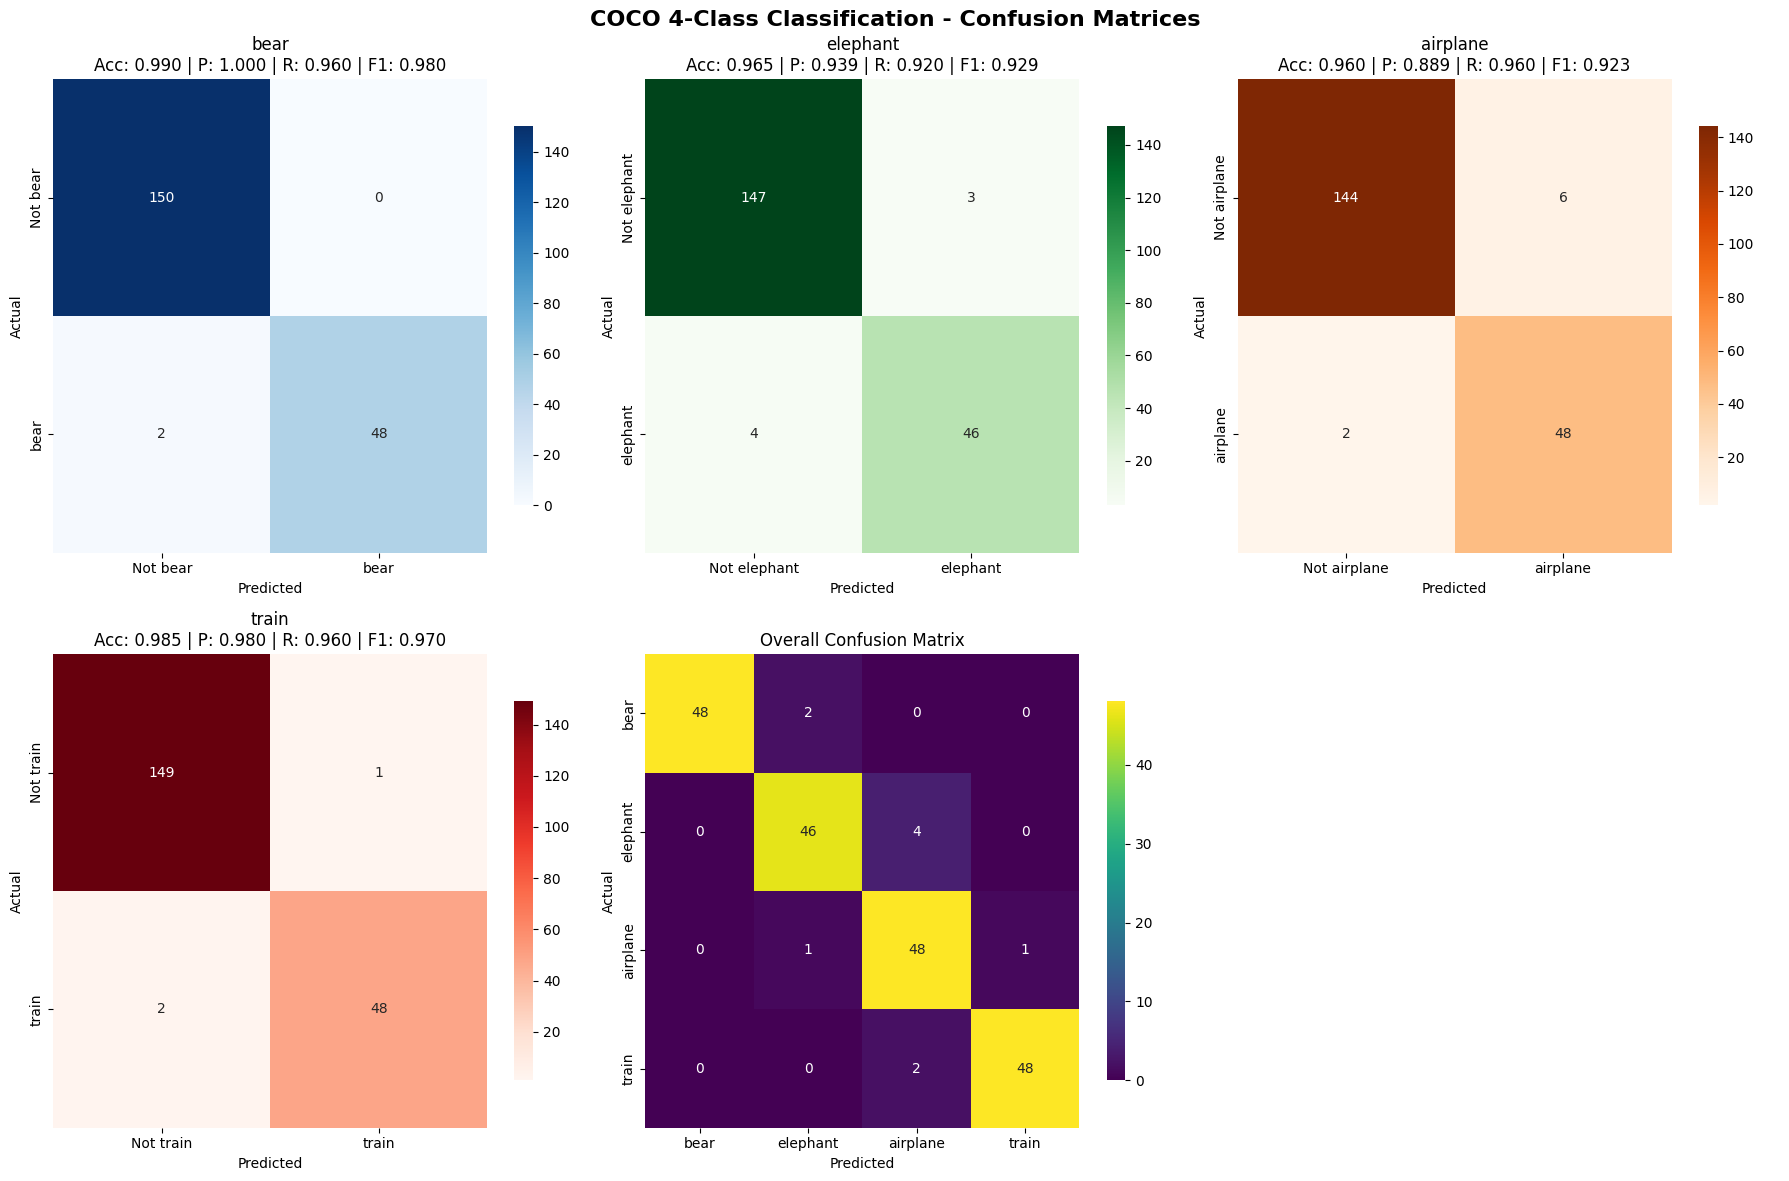


üìà Ë®àÁÆóË©≥Á¥∞Ë©ï‰º∞ÊåáÊ®ô...

üéØ Êï¥È´îÊ∫ñÁ¢∫Áéá: 0.9500 (95.0%)

üìã ÂêÑÈ°ûÂà•Ë©≥Á¥∞ÊåáÊ®ô:
--------------------------------------------------------------------------------
È°ûÂà•           Á≤æÁ¢∫Áéá        Âè¨ÂõûÁéá        F1ÂàÜÊï∏       Ê∫ñÁ¢∫Áéá        ÊîØÊåÅÊï∏       
--------------------------------------------------------------------------------
bear         1.000      0.960      0.980      0.990      50        
  ‚úÖ bear ÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁõÆÊ®ôÔºÅ
elephant     0.939      0.920      0.929      0.965      50        
  ‚úÖ elephant ÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁõÆÊ®ôÔºÅ
airplane     0.889      0.960      0.923      0.960      50        
  ‚úÖ airplane ÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁõÆÊ®ôÔºÅ
train        0.980      0.960      0.970      0.985      50        
  ‚úÖ train ÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁõÆÊ®ôÔºÅ
--------------------------------------------------------------------------------

üìä ÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁöÑÈ°ûÂà•Êï∏: 4/4
üéâ ÊâÄÊúâÈ°ûÂà•ÈÉΩÈÅîÂà∞‰∫Ü95%Ê∫ñÁ¢∫ÁéáÁõÆÊ®ôÔºÅ

üíæ Ë©ï‰º∞ÁµêÊûúÂ∑≤‰øùÂ≠

In [22]:
# ==========================================
# Part 7: Ê®°ÂûãË©ï‰º∞ËàáÊ∑∑Ê∑ÜÁü©Èô£
# ==========================================

def evaluate_model(model, data_loader, device, class_names):
    """
    ÂÆåÊï¥ÁöÑÊ®°ÂûãË©ï‰º∞ÂáΩÊï∏
    Ë®àÁÆóÊï¥È´îÊ∫ñÁ¢∫Áéá„ÄÅÂêÑÈ°ûÂà•Ê∫ñÁ¢∫ÁéáÂíåÊ∑∑Ê∑ÜÁü©Èô£
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    print("Ê≠£Âú®ÈÄ≤Ë°åÊ®°ÂûãË©ï‰º∞...")

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Ë©ï‰º∞‰∏≠'):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # ÂâçÂêëÂÇ≥Êí≠
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            # Êî∂ÈõÜÁµêÊûú
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # ËΩâÊèõÁÇ∫numpyÈô£Âàó
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return all_preds, all_labels, all_probs

def plot_confusion_matrices(y_true, y_pred, class_names):
    """
    Áπ™Ë£ΩÊØèÂÄãÈ°ûÂà•ÁöÑÊ∑∑Ê∑ÜÁü©Èô£ÂíåÊï¥È´îÊ∑∑Ê∑ÜÁü©Èô£
    """
    print("\nüìä ÁîüÊàêÊ∑∑Ê∑ÜÁü©Èô£...")

    # Êï¥È´îÊ∑∑Ê∑ÜÁü©Èô£
    overall_cm = confusion_matrix(y_true, y_pred)

    # Ë®≠ÂÆöÂúñË°®Ê®£Âºè
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('COCO 4-Class Classification - Confusion Matrices', fontsize=16, fontweight='bold')

    # È°èËâ≤Êò†Â∞Ñ
    colors = ['Blues', 'Greens', 'Oranges', 'Reds', 'Purples']

    # Áπ™Ë£ΩÊØèÂÄãÈ°ûÂà•ÁöÑÊ∑∑Ê∑ÜÁü©Èô£
    for i, class_name in enumerate(class_names):
        row = i // 3
        col = i % 3
        ax = axes[row, col]

        # ÁÇ∫Áï∂ÂâçÈ°ûÂà•ÂâµÂª∫‰∫åÂÖÉÊ∑∑Ê∑ÜÁü©Èô£
        # True Positive, False Negative, False Positive, True Negative
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)

        binary_cm = confusion_matrix(y_true_binary, y_pred_binary)

        # Áπ™Ë£ΩÁÜ±Âúñ
        sns.heatmap(binary_cm,
                   annot=True,
                   fmt='d',
                   cmap=colors[i],
                   xticklabels=[f'Not {class_name}', f'{class_name}'],
                   yticklabels=[f'Not {class_name}', f'{class_name}'],
                   ax=ax,
                   cbar_kws={'shrink': 0.8})

        # Ë®àÁÆóË©≤È°ûÂà•ÁöÑÁ≤æÁ¢∫Áéá„ÄÅÂè¨ÂõûÁéáÂíåF1ÂàÜÊï∏
        TP = binary_cm[1, 1]
        FN = binary_cm[1, 0]
        FP = binary_cm[0, 1]
        TN = binary_cm[0, 0]

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        ax.set_title(f'{class_name}\nAcc: {accuracy:.3f} | P: {precision:.3f} | R: {recall:.3f} | F1: {f1:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    # Áπ™Ë£ΩÊï¥È´îÊ∑∑Ê∑ÜÁü©Èô£
    ax_overall = axes[1, 1]
    sns.heatmap(overall_cm,
               annot=True,
               fmt='d',
               cmap='viridis',
               xticklabels=class_names,
               yticklabels=class_names,
               ax=ax_overall,
               cbar_kws={'shrink': 0.8})

    ax_overall.set_title('Overall Confusion Matrix')
    ax_overall.set_xlabel('Predicted')
    ax_overall.set_ylabel('Actual')

    # Èö±ËóèÊúÄÂæå‰∏ÄÂÄãÂ≠êÂúñ
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig('/content/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

    return overall_cm

def calculate_detailed_metrics(y_true, y_pred, y_probs, class_names):
    """
    Ë®àÁÆóË©≥Á¥∞ÁöÑË©ï‰º∞ÊåáÊ®ô
    """
    print("\nüìà Ë®àÁÆóË©≥Á¥∞Ë©ï‰º∞ÊåáÊ®ô...")

    # Êï¥È´îÊ∫ñÁ¢∫Áéá
    overall_accuracy = accuracy_score(y_true, y_pred)

    # ÂàÜÈ°ûÂ†±Âëä
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    print(f"\nüéØ Êï¥È´îÊ∫ñÁ¢∫Áéá: {overall_accuracy:.4f} ({overall_accuracy:.1%})")
    print("\nüìã ÂêÑÈ°ûÂà•Ë©≥Á¥∞ÊåáÊ®ô:")
    print("-" * 80)
    print(f"{'È°ûÂà•':<12} {'Á≤æÁ¢∫Áéá':<10} {'Âè¨ÂõûÁéá':<10} {'F1ÂàÜÊï∏':<10} {'Ê∫ñÁ¢∫Áéá':<10} {'ÊîØÊåÅÊï∏':<10}")
    print("-" * 80)

    # Ë®àÁÆóÂêÑÈ°ûÂà•ÁöÑÊ∫ñÁ¢∫Áéá
    class_accuracies = []
    for i, class_name in enumerate(class_names):
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)

        # Ë®àÁÆóÊ∑∑Ê∑ÜÁü©Èô£ÂÖÉÁ¥†
        TP = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
        TN = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
        FP = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
        FN = np.sum((y_true_binary == 1) & (y_pred_binary == 0))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        class_accuracies.append(accuracy)

        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']

        print(f"{class_name:<12} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {accuracy:<10.3f} {support:<10.0f}")

        # Ê™¢Êü•ÊòØÂê¶ÈÅîÂà∞95%Ê∫ñÁ¢∫Áéá
        if accuracy >= 0.95:
            print(f"  ‚úÖ {class_name} ÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁõÆÊ®ôÔºÅ")
        else:
            print(f"  ‚ùå {class_name} Êú™ÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁõÆÊ®ô (ÁõÆÂâç: {accuracy:.1%})")

    print("-" * 80)

    # Áµ±Ë®àÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁöÑÈ°ûÂà•Êï∏
    classes_above_95 = sum(1 for acc in class_accuracies if acc >= 0.95)

    print(f"\nüìä ÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁöÑÈ°ûÂà•Êï∏: {classes_above_95}/{len(class_names)}")

    if classes_above_95 == len(class_names):
        print("üéâ ÊâÄÊúâÈ°ûÂà•ÈÉΩÈÅîÂà∞‰∫Ü95%Ê∫ñÁ¢∫ÁéáÁõÆÊ®ôÔºÅ")
    else:
        print(f"‚ö†Ô∏è  ÈÇÑÊúâ {len(class_names) - classes_above_95} ÂÄãÈ°ûÂà•Êú™ÈÅîÂà∞95%Ê∫ñÁ¢∫ÁéáÁõÆÊ®ô")

    return {
        'overall_accuracy': overall_accuracy,
        'class_accuracies': dict(zip(class_names, class_accuracies)),
        'classification_report': report,
        'classes_above_95_percent': classes_above_95
    }

# Âü∑Ë°åÊ®°ÂûãË©ï‰º∞
print("ÈñãÂßãË©ï‰º∞Ë®ìÁ∑¥Â•ΩÁöÑÊ®°Âûã...")

# Âú®È©óË≠âÈõÜ‰∏äË©ï‰º∞
val_preds, val_labels, val_probs = evaluate_model(trained_model, val_loader, device, TARGET_CATEGORIES)

# Áπ™Ë£ΩÊ∑∑Ê∑ÜÁü©Èô£
overall_cm = plot_confusion_matrices(val_labels, val_preds, TARGET_CATEGORIES)

# Ë®àÁÆóË©≥Á¥∞ÊåáÊ®ô
detailed_metrics = calculate_detailed_metrics(val_labels, val_preds, val_probs, TARGET_CATEGORIES)

# ‰øùÂ≠òË©ï‰º∞ÁµêÊûú
evaluation_results = {
    'predictions': val_preds.tolist(),
    'true_labels': val_labels.tolist(),
    'probabilities': val_probs.tolist(),
    'confusion_matrix': overall_cm.tolist(),
    'detailed_metrics': detailed_metrics,
    'class_names': TARGET_CATEGORIES
}

# ‰øùÂ≠òÂà∞Êñá‰ª∂
import json
with open('/content/evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print(f"\nüíæ Ë©ï‰º∞ÁµêÊûúÂ∑≤‰øùÂ≠òËá≥: /content/evaluation_results.json")
print("\n‚úÖ Ê®°ÂûãË©ï‰º∞ÂÆåÊàêÔºÅ")